In [1]:
import csv
import re
import pylab
import time
import collections
import numpy as np
import nltk
nltk.download('punkt')
import tensorflow as tf
from nltk.tokenize import word_tokenize
from tensorflow.keras import Model, layers
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

import pickle

from google.colab import drive
drive.mount('/content/gdrive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Mounted at /content/gdrive


In [2]:
# RTX On
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Variables

In [3]:
# Initialise variables to be used later
MAX_DOCUMENT_LENGTH = 100
N_FILTERS = 10
FILTER_SHAPE1 = [20, 256]
FILTER_SHAPE2= [20, 1]
FILTER_SHAPE3 = [20, 20]
POOLING_WINDOW = 4
POOLING_STRIDE = 2
MAX_LABEL = 15
 
batch_size = 128
one_hot_size = 256
no_epochs = 250
lr = 0.01
 
seed = 10
tf.random.set_seed(seed)

# Functions

In [4]:
#Define functions to be used later
#Get all the unique characters used in the string supplied
def vocabulary(strings):
    chars = sorted(list(set(list(''.join(strings)))))
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    vocab_size = len(chars)
    return vocab_size, char_to_ix

#Preprocess strings and truncate if length longer than 100
def preprocess(strings, char_to_ix, MAX_LENGTH):
    data_chars = [list(d.lower()) for _, d in enumerate(strings)]
    for i, d in enumerate(data_chars):
        if len(d)>MAX_LENGTH:
            d = d[:MAX_LENGTH]
        elif len(d) < MAX_LENGTH:
            d += [' '] * (MAX_LENGTH - len(d))
            
    data_ids = np.zeros([len(data_chars), MAX_LENGTH], dtype=np.int64)
    for i in range(len(data_chars)):
        for j in range(MAX_LENGTH):
            data_ids[i, j] = char_to_ix[data_chars[i][j]]
    return np.array(data_ids)

#Read in the data in the train and test csv files
def read_data_chars():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('/content/gdrive/My Drive/Colab Notebooks/train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('/content/gdrive/My Drive/Colab Notebooks/test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))


    vocab_size, char_to_ix = vocabulary(x_train+x_test)
    x_train = preprocess(x_train, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    return x_train, y_train, x_test, y_test


x_train, y_train, x_test, y_test = read_data_chars()

#Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# CNN Training & Testing Functions

In [5]:
# Training and Testing step function for CNN models

#Training function
def train_step(model, x, label, drop_rate):
    #Computes gradient from the recorded "tape"
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

#Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

# Model Definition

In [6]:
# Designing of CharCNN model
tf.keras.backend.set_floatx('float32')
class CharCNN(Model):
    def __init__(self, vocab_size=256):
        super(CharCNN, self).__init__()
        self.vocab_size = vocab_size
        #Weight variables and CNN cell
        self.conv1 = layers.Conv2D(N_FILTERS, FILTER_SHAPE1, padding='VALID', activation='relu', use_bias=True)
        self.pool1 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.conv2 = layers.Conv2D(N_FILTERS, FILTER_SHAPE2, padding='VALID', activation='relu', use_bias=True)
        self.pool2 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(MAX_LABEL, activation='softmax')

    def call(self, x, drop_rate=0.5):
        #forward
        x = tf.one_hot(x, one_hot_size)
        x = x[..., tf.newaxis] 
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = tf.nn.dropout(x, drop_rate)
        logits = self.dense(x)
        return logits

In [7]:
# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

#Select metrics to measure the loss and the accuracy of the model. 
#These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

#Build the model
CharCNN_model = CharCNN(256)

# Train Model

In [8]:
test_acc_CharCNN = []
train_acc_CharCNN= []
test_loss_CharCNN= []
train_loss_CharCNN=[]
charCNN_timer = 0

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    epoch_start_time = time.perf_counter()
    for images, labels in train_ds:
        train_step(CharCNN_model, images, labels, drop_rate=0)

    for images, labels in test_ds:
        test_step(CharCNN_model, images, labels, drop_rate=0)

    epoch_end_time = time.perf_counter()
    charCNN_timer = charCNN_timer + epoch_end_time - epoch_start_time
    
    test_acc_CharCNN.append(test_accuracy.result())
    train_acc_CharCNN.append(train_accuracy.result())
    test_loss_CharCNN.append(test_loss.result())
    train_loss_CharCNN.append(train_loss.result())

    if ( (epoch+1)%50 == 0): 
        print('[Epoch {}]'.format(epoch+1))
        print('⏵Train Loss: {}'.format(train_loss.result()))
        print('⏵Train Acc:  {}'.format(train_accuracy.result()))
        print('⏵Test Loss:  {}'.format(test_loss.result()))
        print('⏵Test Acc:   {}'.format(test_accuracy.result()))
        print('')

print('Time Taken: {} seconds.'.format(charCNN_timer))

[Epoch 50]
⏵Train Loss: 0.3098128139972687
⏵Train Acc:  0.895892858505249
⏵Test Loss:  2.006481409072876
⏵Test Acc:   0.6371428370475769

[Epoch 100]
⏵Train Loss: 0.00028110758285038173
⏵Train Acc:  1.0
⏵Test Loss:  3.3230133056640625
⏵Test Acc:   0.6757143139839172

[Epoch 150]
⏵Train Loss: 4.994889968656935e-05
⏵Train Acc:  1.0
⏵Test Loss:  3.54958438873291
⏵Test Acc:   0.6742857098579407

[Epoch 200]
⏵Train Loss: 1.3824308553012088e-05
⏵Train Acc:  1.0
⏵Test Loss:  3.7067620754241943
⏵Test Acc:   0.6757143139839172

[Epoch 250]
⏵Train Loss: 4.94093137604068e-06
⏵Train Acc:  1.0
⏵Test Loss:  3.8381259441375732
⏵Test Acc:   0.6785714030265808

Time Taken: 139.16631436099976 seconds.


In [9]:
# get highest accuracy values
highest_acc = max(test_acc_CharCNN)

# get average accuracy
average_acc = sum(test_acc_CharCNN)/len(test_acc_CharCNN)

print('Highest Acc')
print(highest_acc)

print('')

print('Avg Acc')
print(average_acc)

Highest Acc
tf.Tensor(0.68142855, shape=(), dtype=float32)

Avg Acc
tf.Tensor(0.6698969, shape=(), dtype=float32)


# Plot

## Loss Plot

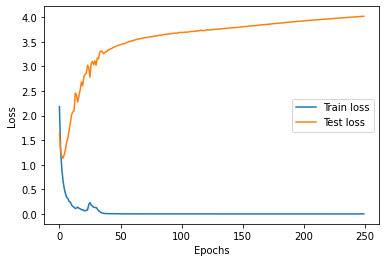

In [ ]:
plt.plot(train_loss_CharCNN,label="Train loss")
plt.plot(test_loss_CharCNN,label="Test loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()
plt.close()

## Accuracy Plot

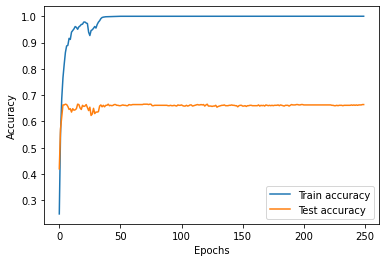

In [ ]:
plt.plot(train_acc_CharCNN,label="Train accuracy")
plt.plot(test_acc_CharCNN,label="Test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()
plt.close()